In [5]:
import matplotlib.pyplot as plt
import numpy as np
from colorplot import *
from perturbed_phot import *
%matplotlib notebook

In [6]:
cat = load_noflag_cat('pkl/catalogDual_pz.pkl')

nb_ind = 11 # J0480
bb_ind = -3 # g
mask_fzero = (cat['MAG'][:, nb_ind] < 90) & (cat['MAG'][:, bb_ind] < 90)

nb_m = cat['MAG'][mask_fzero, nb_ind]
bb_m = cat['MAG'][mask_fzero, bb_ind]
nb_e = cat['ERR'][mask_fzero, nb_ind]
bb_e = cat['ERR'][mask_fzero, bb_ind]

masked_mags = cat['MAG'][mask_fzero, :]
masked_errs = cat['ERR'][mask_fzero, :]

In [7]:
#Define binning
m_min = 14
m_max = 26
m_bin_n = 75
x_e = np.linspace(m_min, m_max, m_bin_n)

bbcut = x_e[np.nanargmin(np.abs(m_err_bin(bb_m, bb_e, x_e, bb_m) - 0.24))]
nbcut = x_e[np.nanargmin(np.abs(m_err_bin(nb_m, nb_e, x_e, nb_m) - 0.24))]

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


1000/1000


<IPython.core.display.Javascript object>


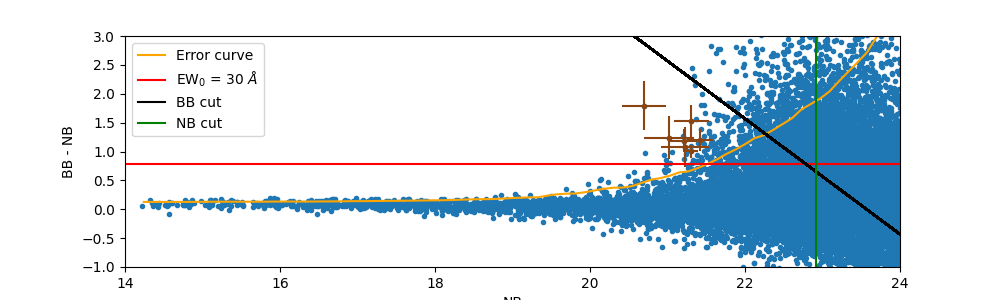

array([ 2562, 19058, 19498, 19979, 21850, 22409, 22484])

In [16]:
n_iter = 1000
tolerance = 0.8

option_curve = (True, False, False)
option_pbp   = (False, True, False)
option_no_er = (False, False, True)


sel_hist = perturbed_phot.perturb_phot(
            nb_m, nb_e, bb_m, bb_e, 30,
            nb_ind, n_iter, bbcut, nbcut,
            *option_curve
        )
selection, = np.where(sel_hist*1./n_iter > tolerance)
make_colorplot(cat, -3, nb_ind, selection, 'NB', False)

In [ ]:
# filename = 'selected_sources/candidate'
# plot_selection(selection, nb_ind, filename, masked_mags, masked_errs, 'NB')